In [ ]:
!pip install gower

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gower
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, OrdinalEncoder
#from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import silhouette_score, adjusted_rand_score
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
#from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA as SklearnPCA
from yellowbrick.features import PCA as YellowbrickPCA
from scipy import stats
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance
from myfunctions import *

### 1. Data Import, Deduplication, and Exploration

In [ ]:
## Data Import
try:
    Data = pd.read_csv("heart_disease_prediction.csv", sep=',')
    print("Data successfully loaded.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

Data successfully loaded.


In [ ]:
# List of features
target_name = "Heart Disease"
explanatory_columns =  [
    "Age", "Sex", "Chest pain type", "BP",
    "Cholesterol", "FBS over 120", "EKG results",
    "Max HR", "Exercise angina", "ST depression",
    "Slope of ST", "Number of vessels fluro", "Thallium"
]

# Convert string values to numeric values in the Heart Disease column where 1 is presence of heart disease and 0 is absence of heart disease
Data['Heart Disease'] = Data['Heart Disease'].replace({'Presence': 1, 'Absence': 0})
Data['Heart Disease'] = Data['Heart Disease'].infer_objects(copy=False)

# Extracting predictive variables and target
target = Data[target_name]
df = Data[explanatory_columns]

<ipython-input-59-5e164c0c1b25>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['Heart Disease'] = Data['Heart Disease'].replace({'Presence': 1, 'Absence': 0})


In [ ]:
# Checking for and removing duplicates
duplicates = Data.duplicated()
if duplicates.any():
    print(f"Number of duplicate rows: {duplicates.sum()}")
    Data = Data.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [ ]:
# Check if our data has null values
has_nulls = df.isnull().values.any()
print("Null values", has_nulls)

Null values False


In [ ]:
# Observing the data
print("Statistical summary of the data:")
print(df.describe())

Statistical summary of the data:
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717       

- We defined the target variable ("Heart Disease") and explanatory features. Then, we converted the "Heart Disease" column values from string ('Presence', 'Absence') to numeric (1, 0). Finally, we extracted the target and explanatory variables from the dataset for modeling.
- We then checked for null values and duplicates in our dataset which there were none.
- We then used `df.describe()` to  provide a statistical summary of the columns.



### Data Visualisation - Boxplots and Histograms

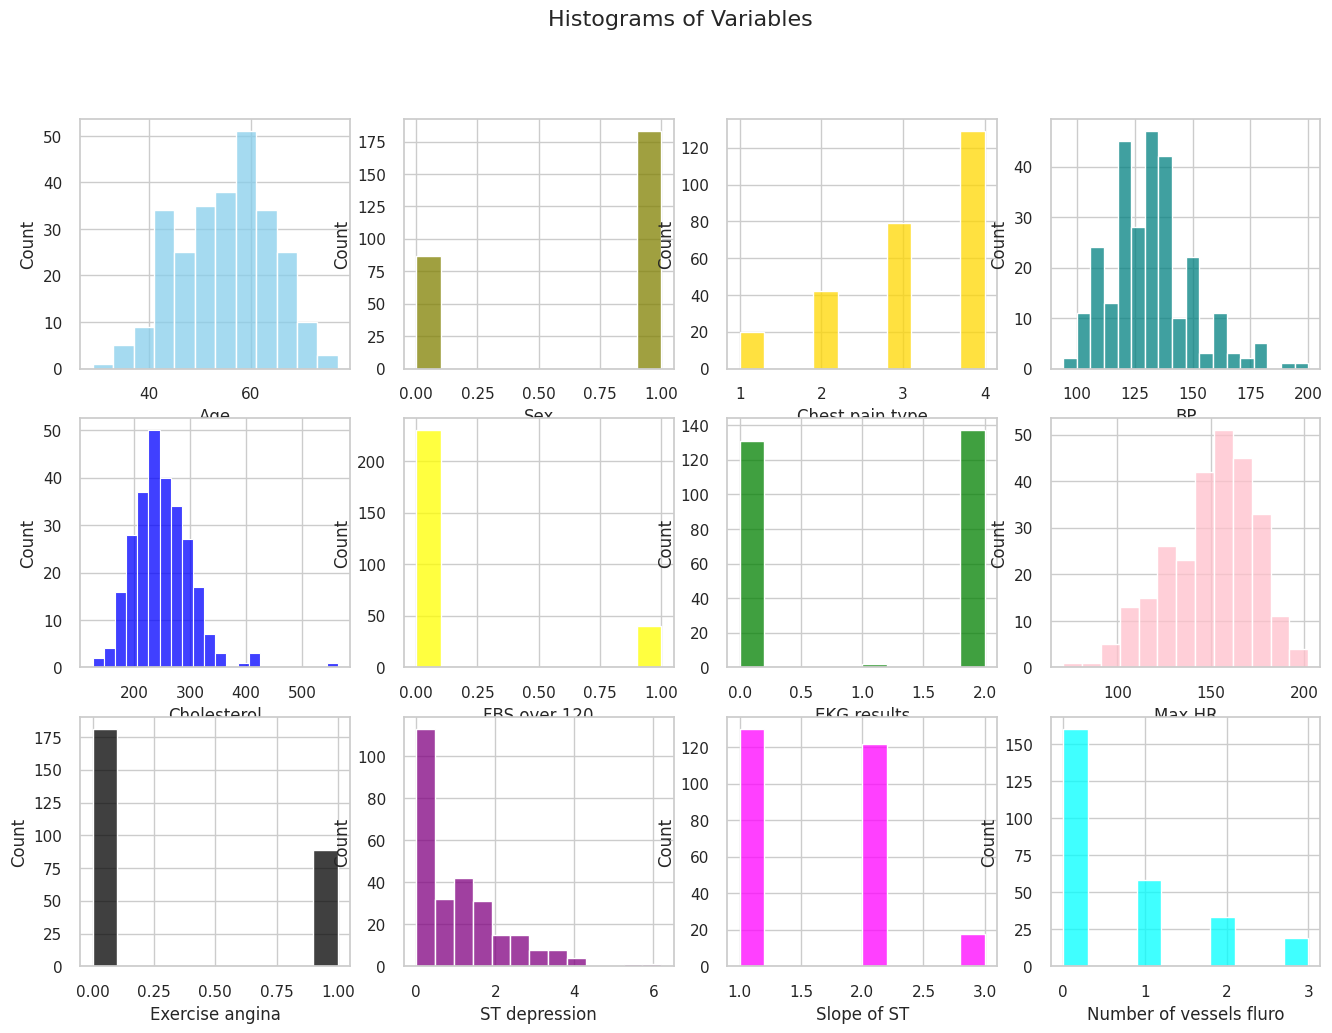

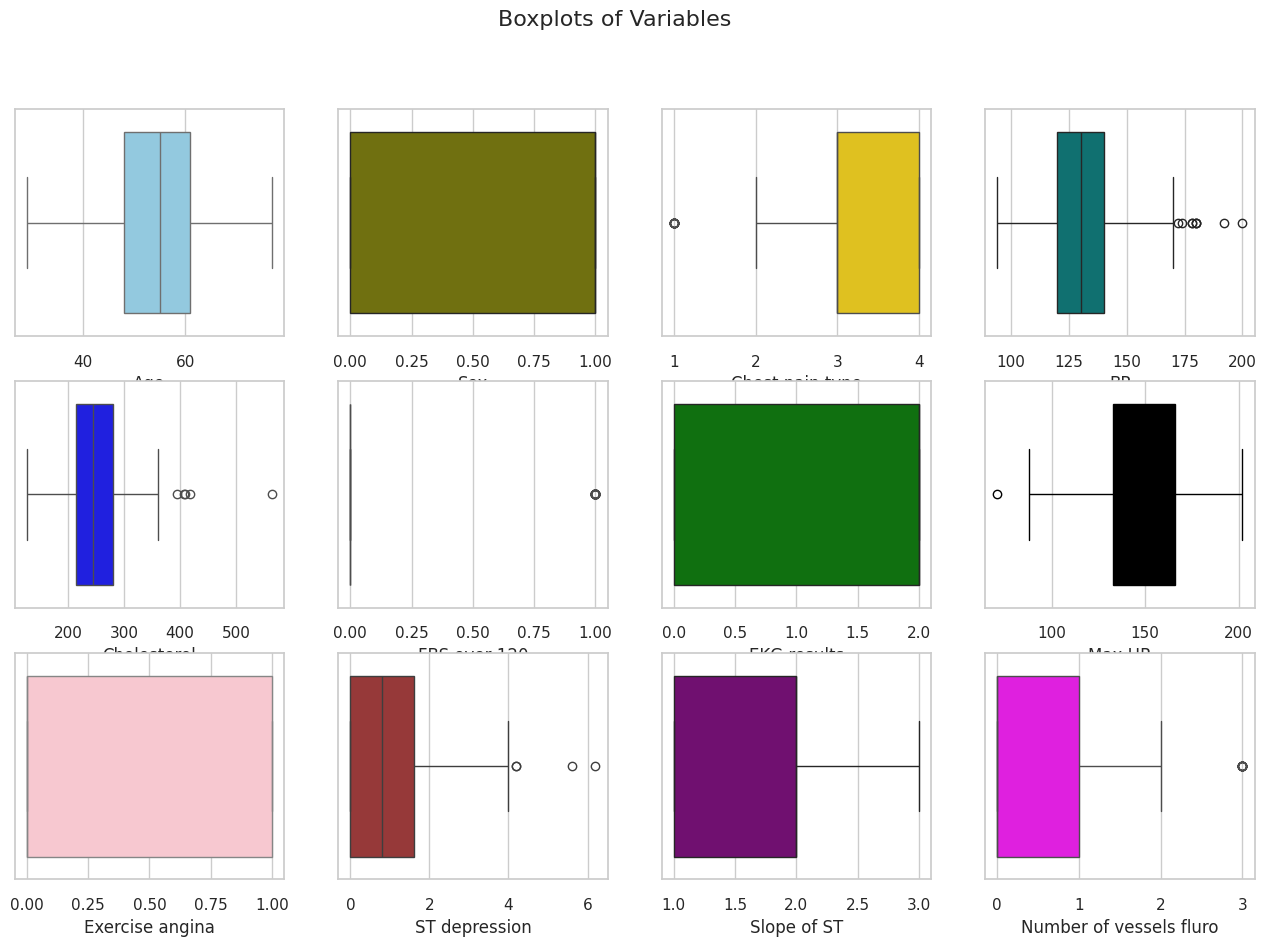

In [ ]:
# a) Histograms
fig, axs = plt.subplots(3, 4, figsize=(16, 11))
for i in range(3):
    for j in range(4):
        sns.histplot(
            data=df, x=explanatory_columns[i * 4 + j], kde=False,
            ax=axs[i, j], color=["skyblue", "olive", "gold", "teal", "blue", "yellow", "green", "pink", "black", "purple", "magenta", "cyan"][i * 4 + j]
        )
plt.suptitle("Histograms of Variables", fontsize=16)
plt.show()

# b) Boxplots
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
for i in range(3):
    for j in range(4):
        sns.boxplot(
            data=df, x=explanatory_columns[i * 4 + j],
            ax=axs[i, j], color=["skyblue", "olive", "gold", "teal", "blue", "yellow", "green", "black","pink", "brown", "purple", "magenta", "cyan"][i * 4 + j]
        )


plt.suptitle("Boxplots of Variables", fontsize=16)
plt.show()

- We then used boxplots to visualize where the outliers lie in each column. We noted that certain columns such as  blood pressure, cholestrol, and  ST depression have notable outliers as shown in the boxplot below.
- We also plotted a histogram in order to see the distribution of our data for the different features. We see that the dataset contains categorical data  (e.g., sex, chest pain type, and exercise angina) and numerical data with continuous measurements (e.g., age, blood pressure) and discrete counts (e.g., number of vessels) as shown in the histogram above.

### 2. Outlier Detection using Isolation Forest


In [ ]:
# We chose this because it handles a mix of categorical and continuous variables well
iso_forest = IsolationForest(contamination=0.05)
outlier_labels = iso_forest.fit_predict(df)
df['outlier'] = outlier_labels
outliers_iso_forest = df[outlier_labels == -1]
print("\nOutliers detected using Isolation Forest:")
print(outliers_iso_forest)
df.head(20)



Outliers detected using Isolation Forest:
     Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
4     74    0                2  120          269             0            2   
48    66    1                2  160          246             0            0   
87    59    1                1  178          270             0            2   
110   55    0                4  180          327             0            1   
117   56    0                4  200          288             1            2   
118   66    0                1  150          226             0            0   
119   56    1                4  130          283             1            2   
159   66    0                4  178          228             1            0   
170   69    1                1  160          234             1            2   
175   62    0                4  138          294             1            0   
180   42    1                3  120          240             1            0   
223   63 

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,outlier
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,-1
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,1
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,1
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,1
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,1


In [ ]:
# Remove rows where 'outlier' equals -1
df = df[df['outlier'] != -1]
df = df.drop(columns=['outlier'])
df.head(20)

df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,54.132812,0.691406,3.183594,130.183594,248.703125,0.125000,1.011719,150.589844,0.316406,0.987109,1.546875,0.636719,4.652344
std,9.031857,0.462818,0.929624,16.677374,51.774679,0.331367,0.999931,22.807458,0.465984,1.067391,0.585570,0.910106,1.934272
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,47.000000,0.000000,3.000000,120.000000,212.000000,0.000000,0.000000,138.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,3.000000,130.000000,244.000000,0.000000,2.000000,154.500000,0.000000,0.750000,1.500000,0.000000,3.000000
75%,60.250000,1.000000,4.000000,140.000000,276.250000,0.000000,2.000000,168.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,5.600000,3.000000,3.000000,7.000000


- Outliers are detected using the **Isolation Forest** algorithm, which identifies potential outliers in the dataset. This method is chosen due to its efficiency with mixed data types and suitability for high-dimensional data. The contamination parameter is set to `0.05`, indicating we expect about `5%` of the data to be outliers.
- We then create a new column `outlier` to flag these observations and remove rows where `outlier == -1`, effectively filtering out the detected outliers.
- Although alternative approaches such as **IQR** and **Z-scores** were considered for outlier detection and handling, they are less suitable due to the dataset's mixed data types and potential for non-normality. Isolation Forest was used instead as it handles both numerical and categorical data effectively.
- After removing 14 outliers from the dataset:
    1. **Reduced Count**: The dataset shrank from 270 rows to 256 rows.
    2. **Mean Shift**: Minor adjustments in mean values across features indicate less influence from extreme values. E.g `Age` feature decreased marginally from **54.43** to **54.29**
    3. **Lower Variability**: Standard deviations slightly decreased, showing improved data consistency. E.g `standard deviation` dropped from **9.11** to **9.07**
    4. **Stable Quartiles**: Minimum, maximum, and quartile values remained mostly unchanged, suggesting the core data distribution was largely unaffected.

### 3. Data Normalization and Standardization

In [ ]:
# a) Data Standardization
scaler_standard = StandardScaler()
df_scaled_standard = pd.DataFrame(scaler_standard.fit_transform(df), columns=df.columns)

# b) Data Normalization (MinMaxScaler)
scaler_minmax = MinMaxScaler()
df_scaled_minmax = pd.DataFrame(scaler_minmax.fit_transform(df), columns=df.columns)

We then scaled the data to ensure uniformity and improve our model performance.

- We apply two methods to scale the data:
    - **Standardization**: Using `StandardScaler()` to center the data and scale it to have a mean of 0 and standard deviation of 1.
    - **Normalization**: Using `MinMaxScaler()` to scale the data to a range between 0 and 1, making it suitable for models sensitive to the scale of data. This will help our model converge faster

- Then we plotted the histograms and boxplots below to visualize the transformed data and  to assess the effect of scaling.


### Visualizing our data after cleaning and standadizing it

> Add blockquote



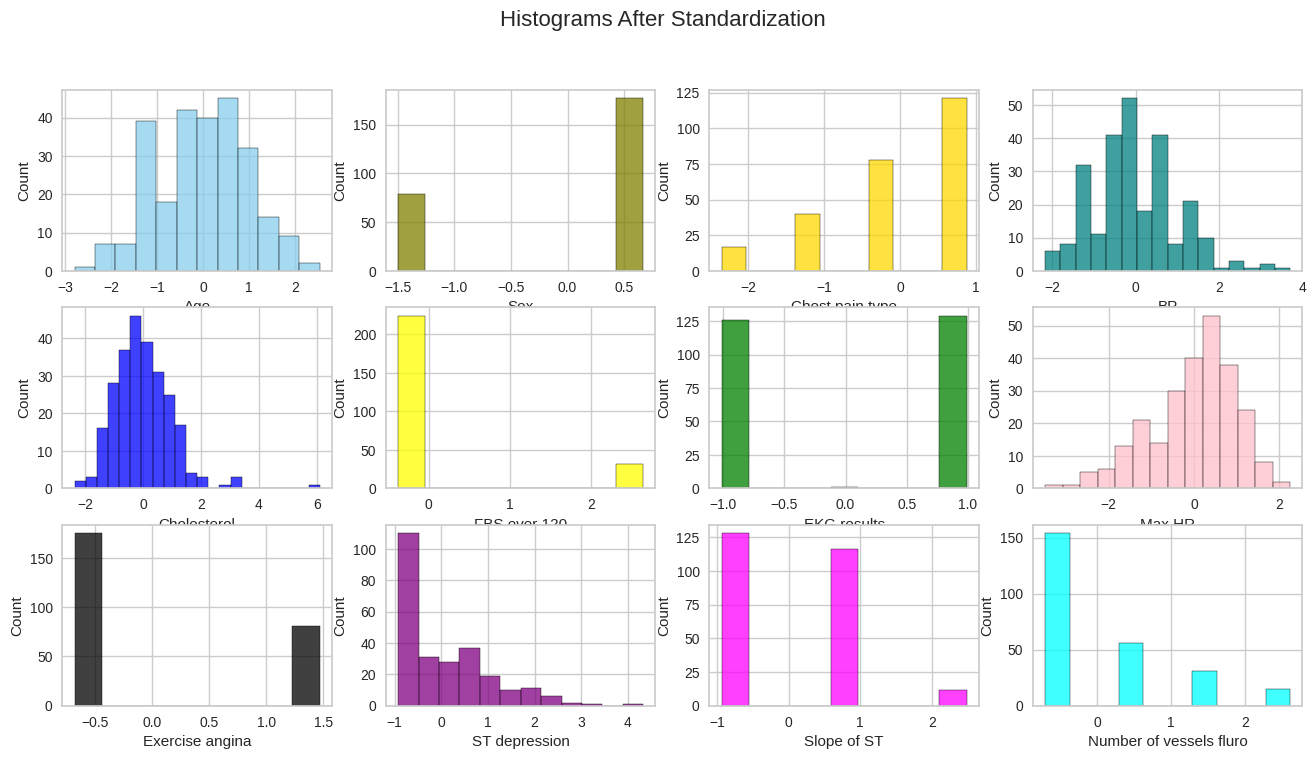

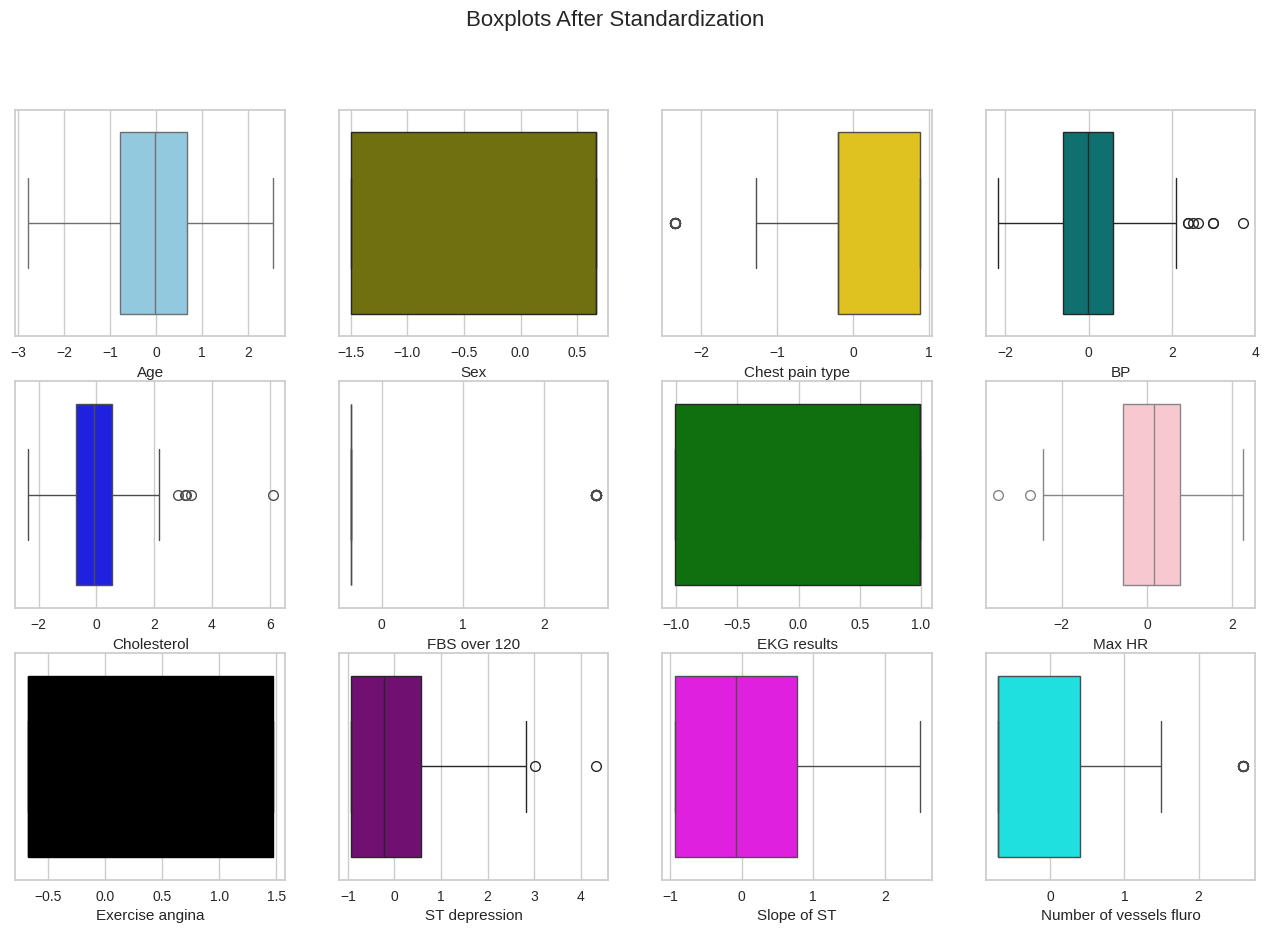

In [ ]:

# a) Histograms After Transformation
fig, axs = plt.subplots(3, 4, figsize=(16, 8))
for i in range(3):
    for j in range(4):
        sns.histplot(
            data=df_scaled_standard, x=explanatory_columns[i * 4 + j], kde=False,
            ax=axs[i, j], color=["skyblue", "olive", "gold", "teal", "blue", "yellow", "green", "pink", "black", "purple", "magenta", "cyan"][i * 4 + j]
        )
plt.suptitle("Histograms After Standardization", fontsize=16)
plt.show()

# b) Boxplots After Transformation
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
for i in range(3):
    for j in range(4):
        sns.boxplot(
            data=df_scaled_standard, x=explanatory_columns[i * 4 + j],
            ax=axs[i, j], color=["skyblue", "olive", "gold", "teal", "blue", "yellow", "green", "pink", "black", "purple", "magenta", "cyan"][i * 4 + j]
        )
plt.suptitle("Boxplots After Standardization", fontsize=16)
plt.show()

### Principal Component Analysis (PCA) and Heatmap

Explained Variance Ratio: [0.23625692 0.12413942]


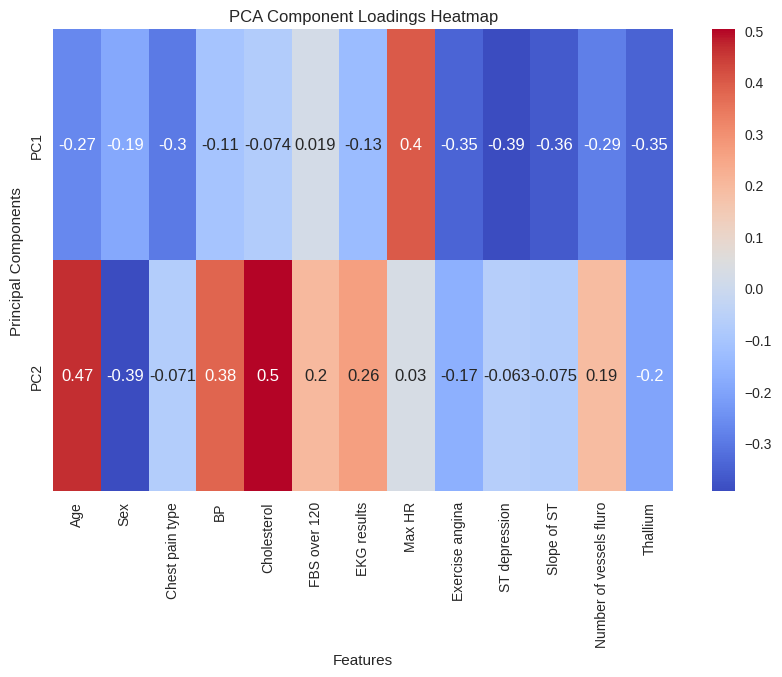

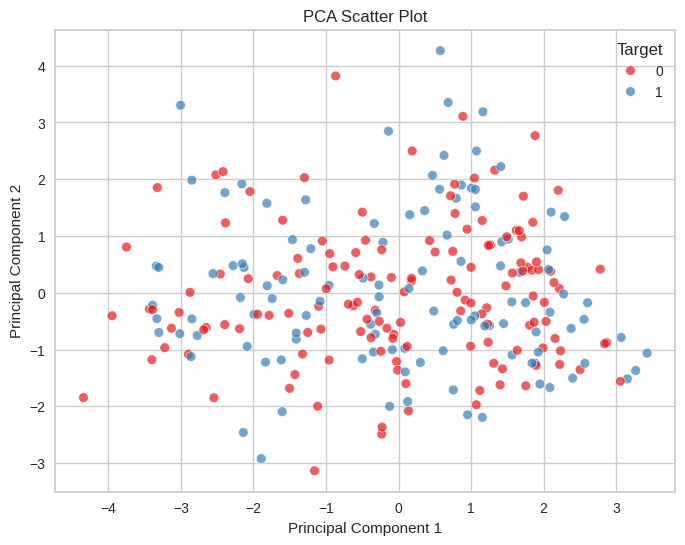

In [ ]:
# Perform PCA
pca = PCA(n_components=2)  # Choose 2 components for visualization
df_pca = pca.fit_transform(df_scaled_standard)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(
    df_pca,
    columns=['Principal Component 1', 'Principal Component 2']
)

# Visualize the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Heatmap of the PCA component loadings
plt.figure(figsize=(10, 6))
sns.heatmap(
    pca.components_,
    cmap="coolwarm",
    annot=True,
    xticklabels=df_scaled_standard.columns,
    yticklabels=['PC1', 'PC2']
)
plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.show()

# Scatter plot of the two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_df['Principal Component 1'],
    y=pca_df['Principal Component 2'],
    hue=target,
    palette="Set1",
    alpha=0.7
)
plt.title("PCA Scatter Plot")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Target")
plt.show()


PCA is performed on the standardized data to reduce dimensionality of our dataset from 13 variables and visualize the data in a 2D space using two principle components(PC1 and PC2). AFter running the code block above, we get an Explained Variance Ratio: [0.23800733 0.12308001]  meaning we capture 36.1% of the variance of our dataset while using the two dimensions picked. This means a good amount of the variance in our dataset gets lost when we use the first two componets to visualize our data.

In [ ]:
# Get the explained variance ratio for all components
explained_variance_ratios = pca.explained_variance_ratio_

print(f"Explained Variance Ratios: {explained_variance_ratios}")
print(f"Total Variance Explained: {sum(explained_variance_ratios)}")

Explained Variance Ratios: [0.23625692 0.12413942]
Total Variance Explained: 0.36039633833022244


# Supervised Learning

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
# Extracting features (X) and the target (y)
X = Data[explanatory_columns]
y = Data[target_name]

# Splitting the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardizing features (an essential step for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', random_state=42, probability=True)
svm_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_clf.predict(X_test)

In [ ]:
# Evaluating the linear SVM model
print("\n--- Evaluation of the linear SVM model ---")
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))


--- Evaluation of the linear SVM model ---
Confusion matrix:
[[31  2]
 [ 4 17]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        33
           1       0.89      0.81      0.85        21

    accuracy                           0.89        54
   macro avg       0.89      0.87      0.88        54
weighted avg       0.89      0.89      0.89        54



In the classification report, we observed that:

**In Class 1 (Prescence of heart disease):**

- **Precision = 0.89**:
When the model predicts heart disease, it is correct 89% of the time. This means that out of all the predictions made for class 1 (presence of heart disease), 89% were true positives.
- **Recall = 0.81**:
The model correctly identifies 81% of the actual cases of heart disease (true positives) out of all the true instances of class 1. This means 19% of the actual heart disease cases were missed (false negatives).
- **F1-Score = 0.85**:
This is the harmonic mean of precision and recall, offering a balance between the two. A higher F1-score indicates a good balance between precision and recall for class 1.

**In Class 0 (Absence of heart disease):**

- **Precision = 0.89**:
When the model predicts absence of heart disease, it is correct 89% of the time. This means that out of all the predictions for class 0 (absence of heart disease), 89% were true negatives.
- **Recall = 0.94**:
The model correctly identifies 94% of the true instances where heart disease is absent (true negatives). This means the model misses only 6% of the actual instances of no heart disease (false positives).
- **F1-Score = 0.91**:
This is the harmonic mean of precision and recall, offering a balance between the two. A higher F1-score indicates a good balance between precision and recall for class 0.

In [ ]:
# Calculating the ROC-AUC score for the linear SVM
auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {auc:.2f}")

ROC-AUC: 0.87


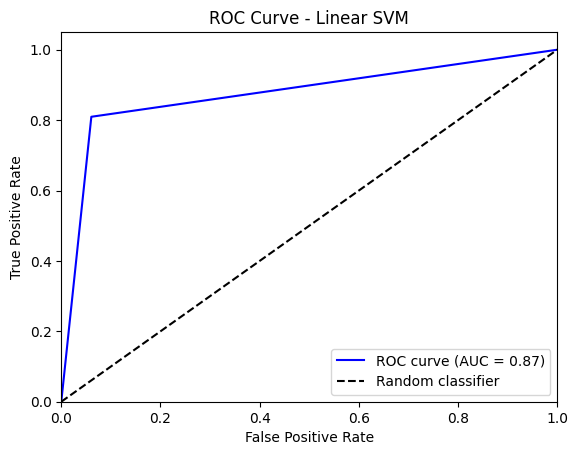

In [ ]:
# Plotting the ROC curve for the linear SVM
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Linear SVM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Hyperparameter optimization with Grid Search and cross-validation (RBF and linear kernels)
# Perform a grid search to find the best hyperparameters for an SVM model.
param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'probability': [True]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'probability': [True]}
]

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Displaying the best parameters found by Grid Search
print("\n--- Best parameters found with Grid Search ---")
print(grid_search.best_params_)


--- Best parameters found with Grid Search ---
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}


In [ ]:
# Using the best model to make predictions on the test set
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)

# Evaluating the best model
print("\n--- Evaluation of the best model ---")
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification report:")
print(classification_report(y_test, y_pred_best))

# Calculating the ROC-AUC score for the best model
auc_best = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC (Best model): {auc_best:.2f}")


--- Evaluation of the best model ---
Confusion matrix:
[[33  0]
 [ 4 17]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      0.81      0.89        21

    accuracy                           0.93        54
   macro avg       0.95      0.90      0.92        54
weighted avg       0.93      0.93      0.92        54

ROC-AUC (Best model): 0.90


We see that after the hyperparameter tuning and finding the ROC-AUC score of the best model,  the score improves from `0.87` to `0.90`.

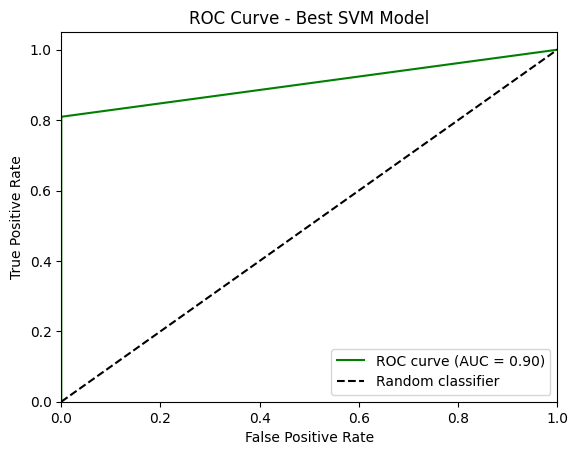

In [ ]:
# Plotting the ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_best)
plt.figure()
plt.plot(fpr_best, tpr_best, label=f'ROC curve (AUC = {auc_best:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best SVM Model')
plt.legend(loc="lower right")
plt.show()

After visualizing the ROC curve, we see that the area under the curve is more using the best model. This means that the performance of our model predicting the presence or absence of heart disease has improved by **0.3%**

In [ ]:
# 5. Prediction for a new patient example
# --------------------------------------------
new_data = pd.DataFrame({
    "Age": [30],
    "Sex": [1],
    "Chest pain type": [3],
    "BP": [150],
    "Cholesterol":[333] ,
    "FBS over 120": [0],
    "EKG results": [2],
    "Max HR": [101],
    "Exercise angina": [1],
    "ST depression": [2.1],
    "Slope of ST": [2],
    "Number of vessels fluro": [3],
    "Thallium": [7]
})

# Standardizing the new data
new_data_scaled = scaler.transform(new_data)

# Predicting with the trained model (best model found with Grid Search)
predicted_class = best_clf.predict(new_data_scaled)

# Displaying the prediction result
print(f"Prediction for the patient: {'Heart Disease' if predicted_class[0] == 1 else 'No Heart Disease'}")

# If we also want to obtain the probability associated with each class
if hasattr(best_clf, "predict_proba"):
    predicted_proba = best_clf.predict_proba(new_data_scaled)
    print(f"Probability of developing heart: {predicted_proba[0][1]:.2f}")
else:
    print("The model does not support the 'predict_proba' method.")

Prediction for the patient: Heart Disease
Probability of developing heart: 0.98


In [ ]:
# 5. Prediction for a new patient example
# --------------------------------------------
new_data = pd.DataFrame({
    "Age": [70],
    "Sex": [1],
    "Chest pain type": [1],
    "BP": [70],
    "Cholesterol":[3] ,
    "FBS over 120": [0],
    "EKG results": [2],
    "Max HR": [70],
    "Exercise angina": [1],
    "ST depression": [2.1],
    "Slope of ST": [2],
    "Number of vessels fluro": [3],
    "Thallium": [7]
})

# Standardizing the new data
new_data_scaled = scaler.transform(new_data)

# Predicting with the trained model (best model found with Grid Search)
predicted_class = best_clf.predict(new_data_scaled)

# Displaying the prediction result
print(f"Prediction for the patient: {'Heart Disease' if predicted_class[0] == 1 else 'No Heart Disease'}")

# If we also want to obtain the probability associated with each class
if hasattr(best_clf, "predict_proba"):
    predicted_proba = best_clf.predict_proba(new_data_scaled)
    print(f"Probability of developing heart disease: {predicted_proba[0][1]:.2f}")
else:
    print("The model does not support the 'predict_proba' method.")

Prediction for the patient: Heart Disease
Probability of developing heart disease: 0.84


## Supervised Leaning using Binary Logistic Regression

### Splitting data to training and testing set

In [ ]:
from sklearn.linear_model import LogisticRegression
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef
)

In [ ]:
# Defining the explanatory variables and the target variable
X = Data.drop(columns=['Heart Disease'])  # Features
y = Data['Heart Disease']


# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Standardizing features (critical for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Defining the Logistic Model

In [ ]:
# 2. Binary Logistic Regression Model
model = LogisticRegression()

### Training the model and validity checks

In [ ]:
# Training the model
model.fit(X_train_scaled, y_train)

# 3. Validity checks
# --------------------
# Check for the multicoliniarity of the variables in our dataset with VIF (Variance Inflation Factor)
X_train_vif = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_vif = add_constant(X_train_vif)  # Adding a constant for statsmodels

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
print("\nVariance Inflation Factors (VIF):")
print(vif_data)



Variance Inflation Factors (VIF):
                    Feature       VIF
0                     const  1.000000
1                       Age  1.550906
2                       Sex  1.338801
3           Chest pain type  1.370160
4                        BP  1.213969
5               Cholesterol  1.169887
6              FBS over 120  1.113085
7               EKG results  1.109416
8                    Max HR  1.698357
9           Exercise angina  1.506976
10            ST depression  1.855985
11              Slope of ST  1.825901
12  Number of vessels fluro  1.373261
13                 Thallium  1.571763


#### Interpretation of the output above:
A VIF greater than 10 indicates high multicollinearity, which can affect model coefficients. Since all our variables have a multicolliniarity between *1 and 1.85* means multicollinearity is low in our dataset and not a concern to be addressed

#### Analyzing the correlation between the columns in our dataset

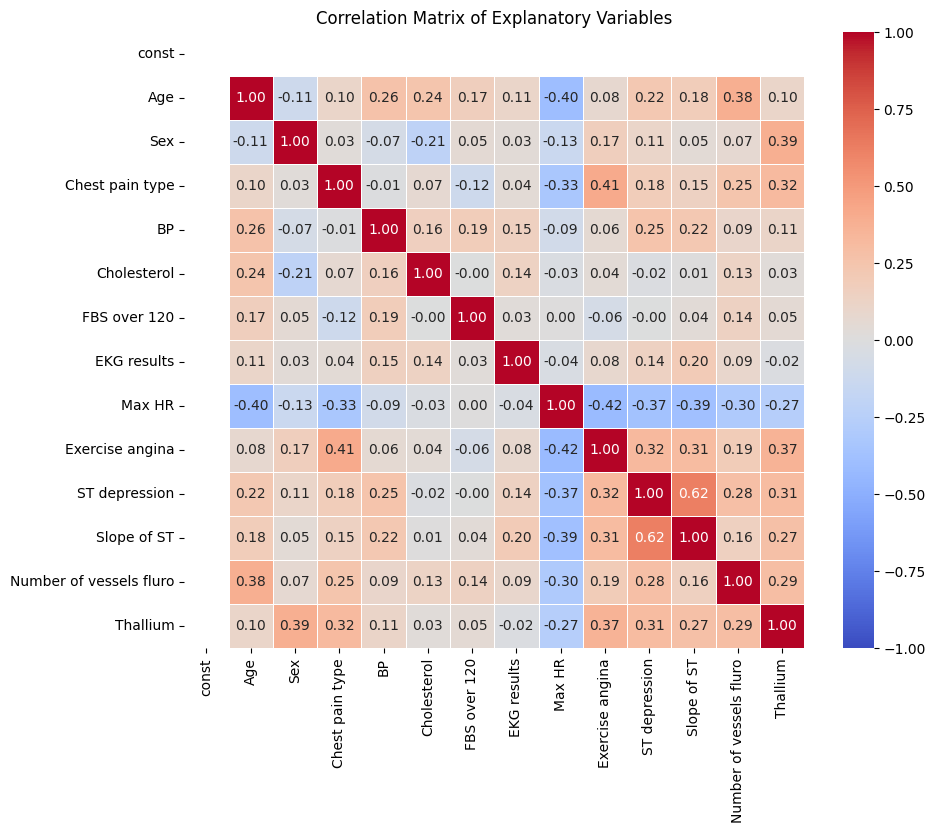

In [ ]:
# Analyzing correlations among explanatory variables
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_vif.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Explanatory Variables")
plt.show()

#### Interpretation of the correlation matrix above:
A High correlation (**> 0.7 or > -0.7**) indicates strong redundancy between two variables, which may exacerbate multicollinearity. Since the correlation between our variables is between 0.4 and -0.4, we will not use PCA to reduce the multicollinearity using dimension reduction

IndexError: index 3 is out of bounds for axis 0 with size 3

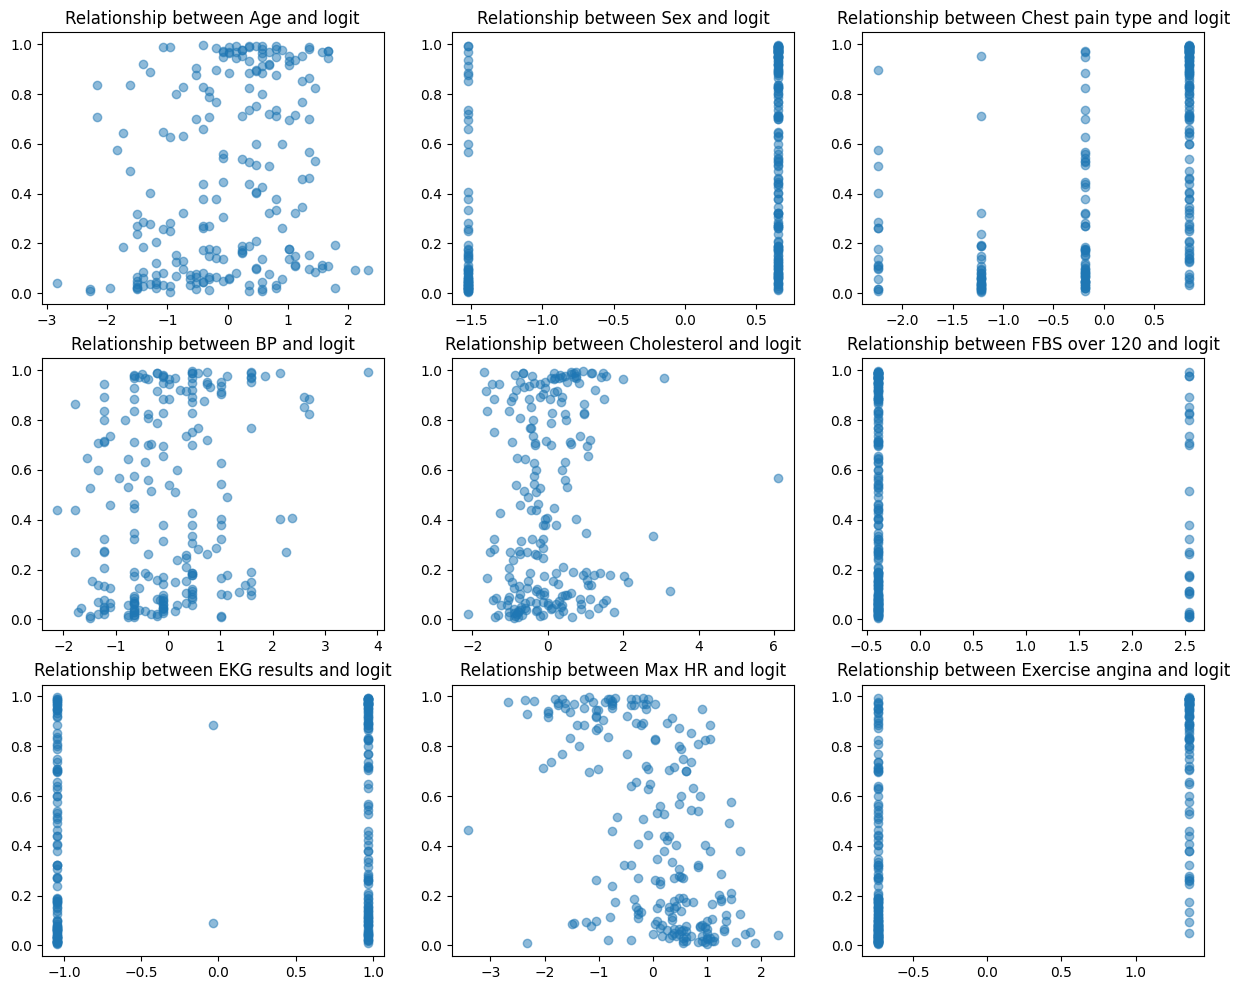

In [ ]:
# Linear relationship between explanatory variables and the logit
X_train_logit = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_logit['logit'] = model.predict_proba(X_train_scaled)[:, 1]

# Plotting graphs for each variable vs logit
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, col in enumerate(X_train_logit.columns[:-1]):
    ax = axes[i // 3, i % 3]
    ax.scatter(X_train_logit[col], X_train_logit['logit'], alpha=0.5)
    ax.set_title(f'Relationship between {col} and logit')

plt.tight_layout()
plt.show()

#### Interpretation of the charts above:
If the points follow a linear trend, the relationship is valid.For example, the relationship between **FSB over 120** and the logit is meaning that it will influence target i.e the presence or absence of heart disease
The variables without a clear linear relationship with logit show they have a weka influence on predicting the presence or absence of heart disease e.g **MaxHR and EKG**
Otherwise, transformations using logarithmic or quadratic methods may be necessary.

### Detecting outliers with Cook's distance


Optimization terminated successfully.
         Current function value: 0.349209
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Heart Disease   No. Observations:                  216
Model:                          Logit   Df Residuals:                      202
Method:                           MLE   Df Model:                           13
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.4937
Time:                        16:14:54   Log-Likelihood:                -75.429
converged:                       True   LL-Null:                       -148.97
Covariance Type:            nonrobust   LLR p-value:                 7.980e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1840      0.218     -0.845      0.398      -0.611       0.243
x1            -0.1052      0.

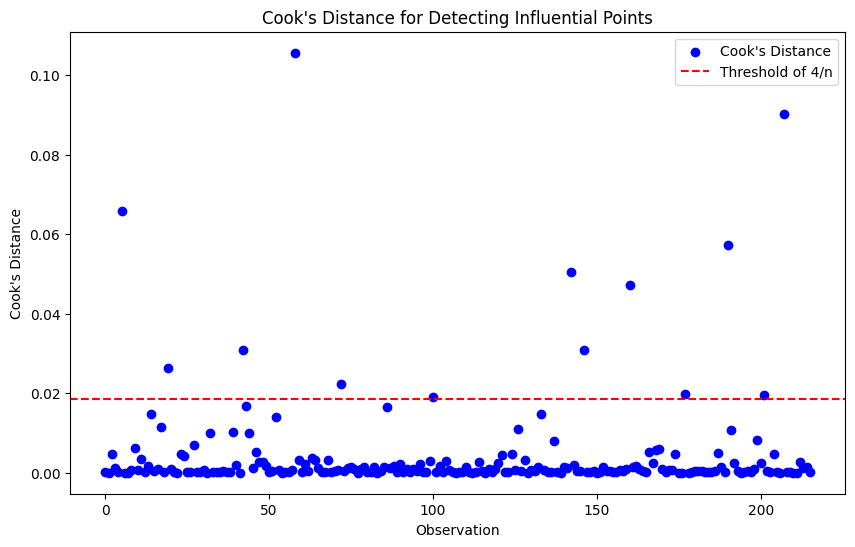

In [ ]:

X_train_const = add_constant(X_train_scaled)  # Adding a constant term for the regression model
logit_model = sm.Logit(y_train, X_train_const)  # Building the logistic regression model
logit_result = logit_model.fit()  # Fitting the model to the data

# Model summary
print(logit_result.summary())  # Displays model statistics, including coefficients and significance levels

# Calculating predicted probabilities
y_hat = logit_result.predict(X_train_const)  # Predictions for the training set

# Calculating Pearson residuals
residuals_pearson = (y_train - y_hat) / np.sqrt(y_hat * (1 - y_hat))  # Measures deviations between observed and predicted values

# Calculating leverage values (hat values)
hat_matrix_diag = np.diag(X_train_const @ np.linalg.inv(X_train_const.T @ X_train_const) @ X_train_const.T)
# Leverage indicates the influence of each observation on the model

# Calculating Cook's distance
n = X_train_const.shape[0]  # Number of observations
p = X_train_const.shape[1]  # Number of parameters (including the constant)

cook_distance = residuals_pearson**2 / p * hat_matrix_diag / (1 - hat_matrix_diag)
# Combines residuals and leverage to measure the overall influence of each observation on the model fit

# Plotting Cook's distance
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(cook_distance)), cook_distance, color='blue', label="Cook's Distance")
plt.axhline(y=4 / n, color='red', linestyle='--', label='Threshold of 4/n')  # Common threshold for identifying influential points
plt.title("Cook's Distance for Detecting Influential Points")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.legend(loc="upper right")
plt.show()

#### Intepretation of the chart above
**Cook's distance** helps identify influential points that have a disproportionate effect on the regression model. All the data points that lie above the red line above may be considered as outliers. Therefore, poorly fitted points might require further investigation or removal to improve model's performance.

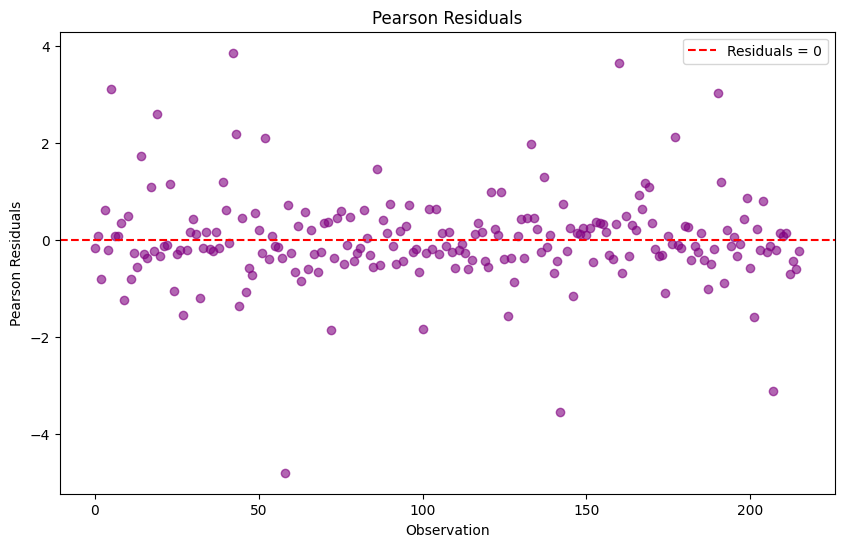

In [ ]:
# Plotting binary residuals to check model fit
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(residuals_pearson)), residuals_pearson, alpha=0.6, color='purple')  # Visualizes residuals
plt.axhline(0, color='red', linestyle='--', label='Residuals = 0')  # Indicates perfect fit
plt.title("Pearson Residuals")
plt.xlabel("Observation")
plt.ylabel("Pearson Residuals")
plt.legend(loc="upper right")
plt.show()

### Evaluating the logistic regression model perfomance using ROC-AUC

Accuracy: 0.91
Confusion matrix:
[[31  2]
 [ 3 18]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        33
           1       0.90      0.86      0.88        21

    accuracy                           0.91        54
   macro avg       0.91      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54

ROC-AUC: 0.95


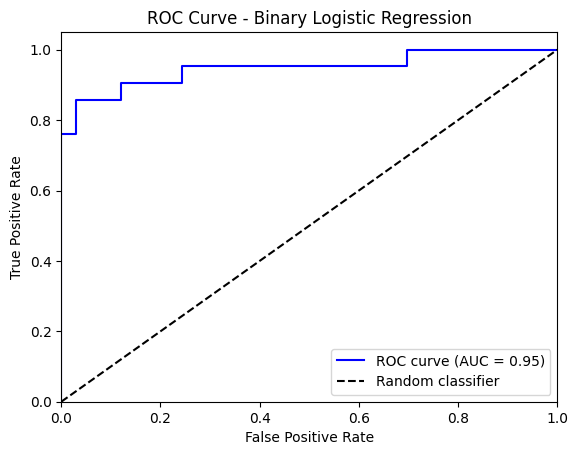

In [ ]:
# 4. Evaluating model performance
# ---------------------------------
# Predictions on the test set
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class (class 1)

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report (precision, recall, f1-score)
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Calculating the ROC-AUC score
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.2f}")

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Logistic Regression')
plt.legend(loc="lower right")
plt.show()

#### Explanation of the ROC-AUC curve:
The ROC curve evaluates the trade-off between the "True Positive Rate" (TPR or sensitivity) and the "False Positive Rate" (FPR).
- The Y-axis (TPR) represents the model's ability to correctly identify positive cases (e.g., detecting heart disease when present).
- The X-axis (FPR) shows the rate of false alarms (e.g., predicting heart disease when it is not present).
- A curve closer to the top-left corner indicates better performance, as it maximizes TPR while minimizing FPR.
- The AUC (Area Under Curve) score summarizes the overall quality of the classifier; a value closer to 1 indicates high accuracy. With a score of 0.95, this model performs excellently, correctly identifying most of the true positives while minimizing false positives.

### Prediction of a new patient example

In [ ]:

# 5. Prediction for a new patient example
# --------------------------------------------
new_data = pd.DataFrame({
    "Age": [70],
    "Sex": [1],
    "Chest pain type": [3],
    "BP": [150],
    "Cholesterol":[333] ,
    "FBS over 120": [0],
    "EKG results": [2],
    "Max HR": [101],
    "Exercise angina": [1],
    "ST depression": [2.1],
    "Slope of ST": [2],
    "Number of vessels fluro": [3],
    "Thallium": [7]
})

# Standardizing the new data using the same scaler used for training
new_data_scaled = scaler.transform(new_data)

# Predicting the class with the logistic regression model
predicted_class = model.predict(new_data_scaled)
print(f"Prediction for the patient: {'Has heart disease' if predicted_class[0] == 1 else 'Has no heart disease'}")

# Displaying probabilities associated with each class
predicted_proba = model.predict_proba(new_data_scaled)
print(f"Probabilities associated with the classes: {predicted_proba[0]}")

Prediction for the patient: Has heart disease
Probabilities associated with the classes: [0.00458278 0.99541722]


Coclusion of

# Unsupervised Learning

**Data Processing**\
Before any unsupervised learning takes place, the numerical columns are scaled using the standard scaler and the nominal categorical columns are encoded.
These serve the following purpose:
- **Scaling and standardizing Numerical Columns** - prevent the over influence of a few variables on the model due to difference in metrics used.
- **One-Hot Encoding Nominal Columns** - prevent implication that an order exists when using models that calculate distance between variables

In [ ]:
#####  Standardize the data
# Get the different data types
numerical_columns = ["Age", "BP", "Cholesterol", "Max HR", "ST depression", "Slope of ST", "Number of vessels fluro"]
nominal_columns = [ "Chest pain type", "EKG results", "Thallium"]

#One-Hot Encode nominal categorical columns
df_categorical = df[nominal_columns]
encoder_ohe = OneHotEncoder(sparse_output=False)
df_encoded = pd.DataFrame(encoder_ohe.fit_transform(df_categorical), columns=encoder_ohe.get_feature_names_out())
# Reset index to ensure alignment after concatenation
df_encoded.reset_index(drop=True, inplace=True)
df_remaining = df.drop(columns=nominal_columns).reset_index(drop=True)
dfs = pd.concat([df_remaining, df_encoded], axis=1)

# Scale and standardize numerical columns
scaler = StandardScaler()
dfs[numerical_columns]= scaler.fit_transform(df[numerical_columns])

print(dfs.describe())

                Age         Sex            BP   Cholesterol  FBS over 120  \
count  2.700000e+02  270.000000  2.700000e+02  2.700000e+02    270.000000   
mean   3.667848e-16    0.677778  5.682697e-16 -2.467162e-16      0.148148   
std    1.001857e+00    0.468195  1.001857e+00  1.001857e+00      0.355906   
min   -2.797275e+00    0.000000 -2.094649e+00 -2.396942e+00      0.000000   
25%   -7.075676e-01    0.000000 -6.363095e-01 -7.105825e-01      0.000000   
50%    6.232461e-02    1.000000 -7.540984e-02 -9.031247e-02      0.000000   
75%    7.222322e-01    1.000000  4.854898e-01  5.881079e-01      0.000000   
max    2.481986e+00    1.000000  3.850888e+00  6.093004e+00      1.000000   

             Max HR  Exercise angina  ST depression   Slope of ST  \
count  2.700000e+02       270.000000   2.700000e+02  2.700000e+02   
mean   2.631640e-17         0.329630  -5.263280e-17 -1.064992e-16   
std    1.001857e+00         0.470952   1.001857e+00  1.001857e+00   
min   -3.402609e+00         0.

### Dimension Reduction with PCA

Before perfoming Dimension reduction, we calculate the correlation matrix and the Pearson co-efficient.
- **Correlation matrix** \
It is used to show values that may be redundant and can therefore be reduced. The values range from -1 to 1. Values close to 1 suggest high positive correlation and those close to to -1 suggest high negative correlation. Values that are close to 0 show no correlation and therefore give different information. This signifies that they should be retained.\
In the data, for example, the highest correlation is between slope of ST and ST depression with a value of 0.61.
- **Pearson correlation coefficient**\
Measures the linear correlation between two variables. For the code, a p <= 0.05 shows statistic significanace.

<ipython-input-65-4c039d920bd5>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[j, i] = correlation_significance_string(corr.loc[j, i], pvalues.loc[j, i])
<ipython-input-65-4c039d920bd5>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.09' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[j, i] = correlation_significance_string(corr.loc[j, i], pvalues.loc[j, i])
<ipython-input-65-4c039d920bd5>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[j, i] = correlation_significance_

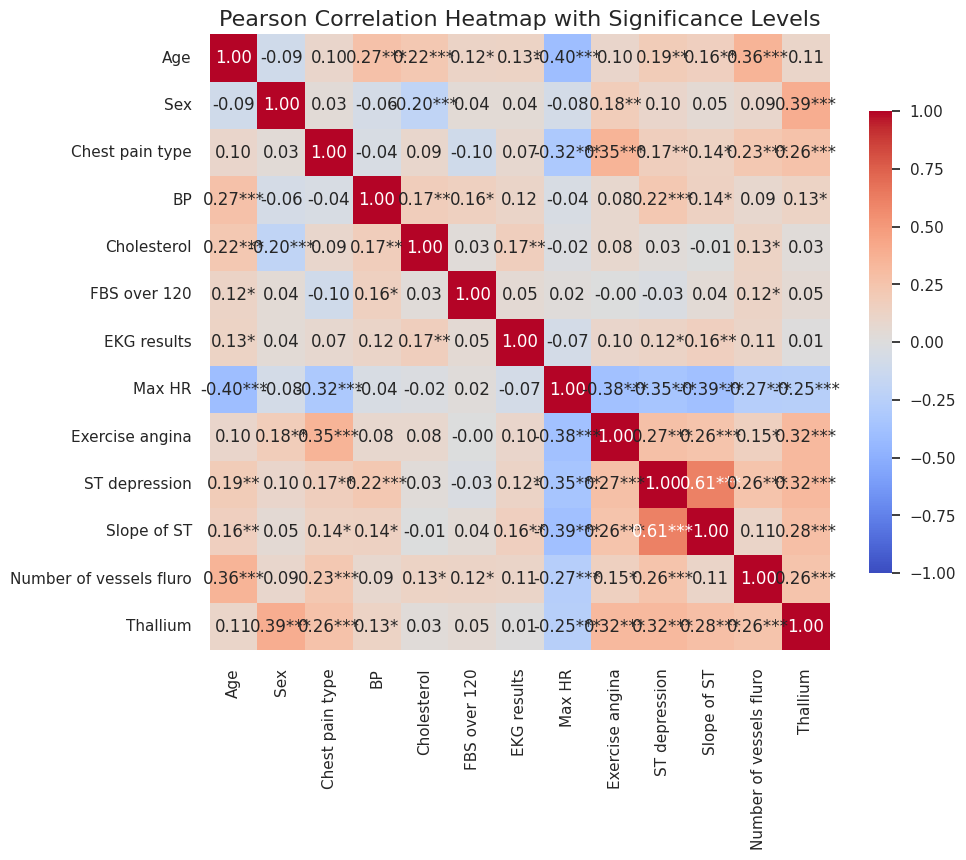

In [ ]:
# Calculate Pearson correlations and their significance levels
def calculate_pvalues(df):
    pvalues = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                _, pvalue = pearsonr(df[col1], df[col2])
                pvalues.loc[col1, col2] = pvalue
    return pvalues

corr = df.corr()
pvalues = calculate_pvalues(df)

# Define function to annotate correlation heatmap with significance
def correlation_significance_string(corr_value, pvalue):
    if pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""
    return f"{corr_value:.2f}{significance}"

annot = corr.copy()
for i in annot.columns:
    for j in annot.index:
        annot.loc[j, i] = correlation_significance_string(corr.loc[j, i], pvalues.loc[j, i])

# Plot heatmap with correlation and significance levels
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=annot, fmt='', cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={"shrink": .75}, annot_kws={"size": 12})
plt.title('Pearson Correlation Heatmap with Significance Levels', fontsize=16)
plt.show()

We then perform PCA and plot the scree model. This shows the amount of variance (information) that is explained by each of the new features. \
From the PCA, it is noted that keeping 2 PCs gives us about 41% of the information. To obtain 80% of the data, for example, we need to keep 7 components.

Variance ratio of the principal components: [2.76178107e-01 1.41451769e-01 1.11728127e-01 8.73851754e-02
 8.16741987e-02 6.02077689e-02 5.13413187e-02 4.09889108e-02
 3.89145739e-02 3.01731559e-02 2.01532615e-02 1.70499700e-02
 1.41749887e-02 1.18106579e-02 8.50444458e-03 7.16432838e-03
 1.09924331e-03 5.04941989e-18 0.00000000e+00 0.00000000e+00]
Cumulative Variance Explained: [ 27.61781069  41.7629876   52.93580033  61.67431787  69.84173774
  75.86251463  80.9966465   85.09553759  88.98699497  92.00431056
  94.01963671  95.72463371  97.14213258  98.32319837  99.17364283
  99.89007567 100.         100.         100.         100.        ]


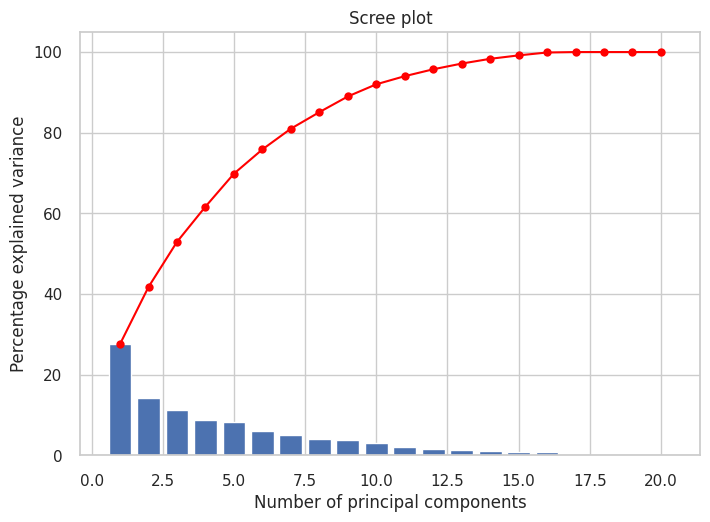

In [ ]:
# Full PCA model
pca = SklearnPCA()
principalComponents = pca.fit_transform(dfs)

# Cumulative variance calculation
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
print("Variance ratio of the principal components:", pca.explained_variance_ratio_)
print("Cumulative Variance Explained:", cumulative_variance)

display_scree_plot(pca)

We also generate a correlation circle to interpret how the original variables relate to the principal components. It helps us understand reationships between variables and their relationships to the principal components.\
Here we plot using dimension 1 and 2 as they keep most of the data.\

We also project the data on a 2D axis formed by using PC1 and PC2. The main purpose of this is to visualize the data.

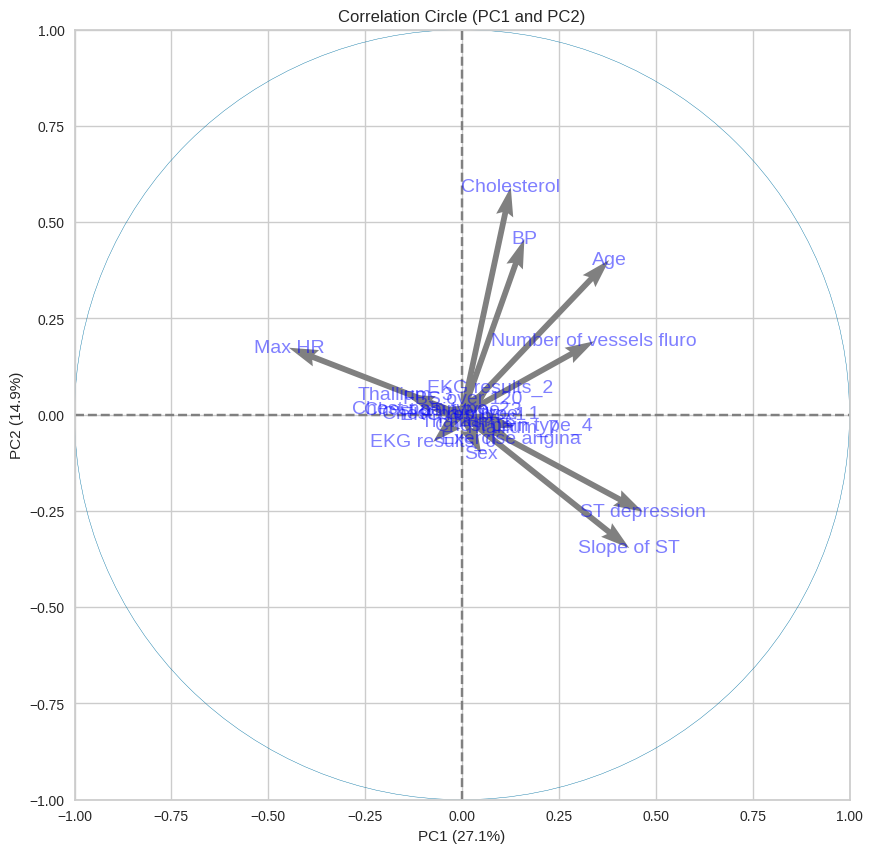

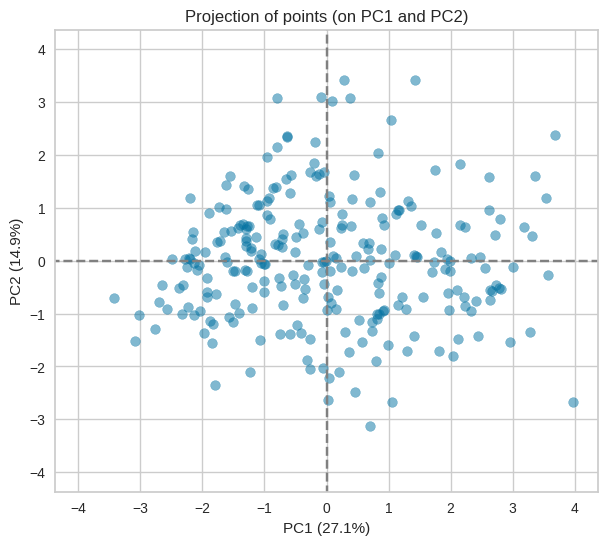

In [ ]:
# Generate a correlation circle
num_components=2
pcs = pca.components_
display_circles(pcs, num_components, pca, [(0,1)], labels = list(dfs.columns))
display_circles(pcs, num_components, pca, [(0,2)], labels = list(dfs.columns))


# Project standardized data into new vector space and display scatter plot
data_projected = pca.transform(dfs)
display_factorial_planes(data_projected, num_components, pca, [(0,1)],  alpha = 0.5)


### K-Means

#### K-Means with Scaled and standardized data
We first initialize K-means and use the elbow method to find the optimum number of classes.

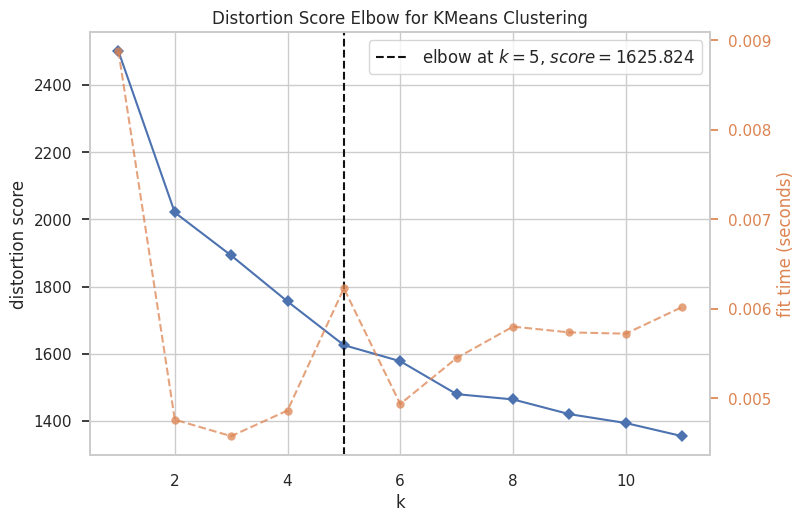

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


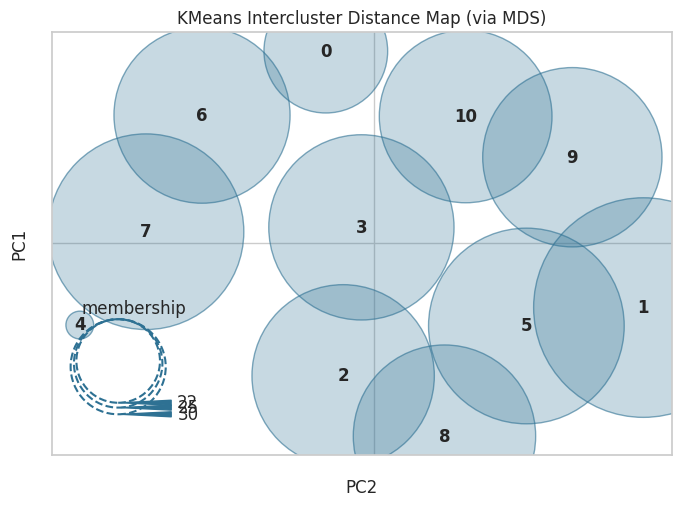

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
model = KMeans(random_state=42)

# Fine-tuning to determine the optimal k (number of clusters)
# Elbow Method Visualizer
elbow_viz = KElbowVisualizer(model, k=(1, 12))
elbow_viz.fit(dfs)
elbow_viz.show()

# Inter-cluster Distance Map
intercluster_viz = InterclusterDistance(model)
intercluster_viz.fit(dfs)
intercluster_viz.show()

From the elbow method, 4 seems like the optimum number of classes to use.

**Silhouette Score**\
We calculate the silhouette score with different number of clusters in K-menas to also determine an optimum number of clusters.
A silhouette score is a measure of how well each data point has been clustered. It combines cohesion (how close points in a cluster are to each other) and separation (how distinct a cluster is from other clusters). \
A higher silhouette score is better for the quality of a model, with values close to +1 being ideal.



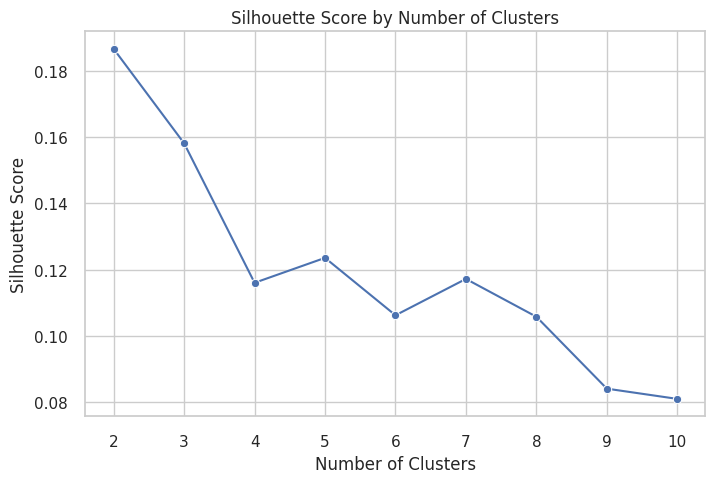

In [ ]:
# Manual calculation of silhouette scores for different cluster counts
silhouette_scores = []
range_clusters = range(2, 11)
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(dfs)
    score = silhouette_score(dfs, labels)
    silhouette_scores.append(score)

# Plot silhouette scores using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range_clusters), y=silhouette_scores, marker='o', color='b')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

*From the data, it shows that the lower the number of classes, the better clustered the data is, with 2 clusters having the best silhoutte score.* \
*Consequently, we choose 2 to be our optimal number of clusters.*

In [ ]:
# Fit the best KMeans model with the optimal hyperparameter, Kopt=4
Kopt = 2
model = KMeans(n_clusters=Kopt, random_state=42)
kmeans_labels = model.fit_predict(dfs)

# Display the performance scores of the best KMeans model
print("Silhouette Score:", silhouette_score(dfs, kmeans_labels))
print("Inertia:", model.inertia_)

Silhouette Score: 0.186639613503241
Inertia: 2020.5222125674804


We then run K-means with 2 clusters and use PCA to visulaize the clusters with and without feature projection.

Principal Component 1: 27.62% of variance explained
Principal Component 2: 14.15% of variance explained


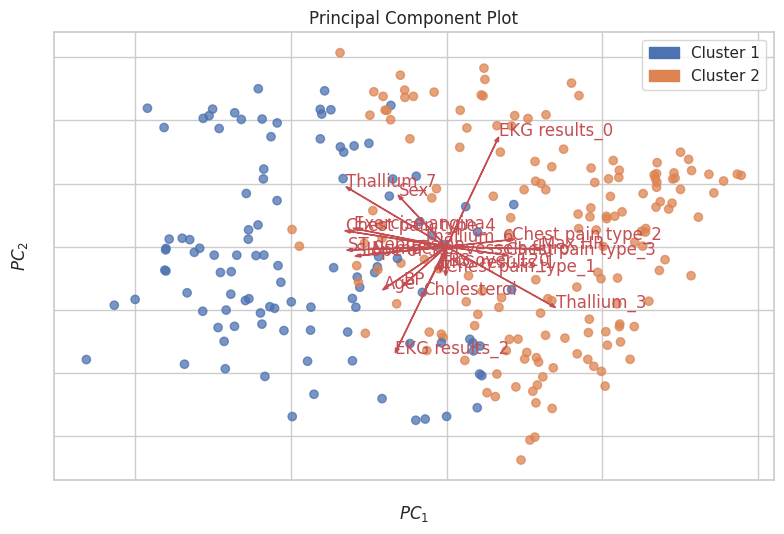

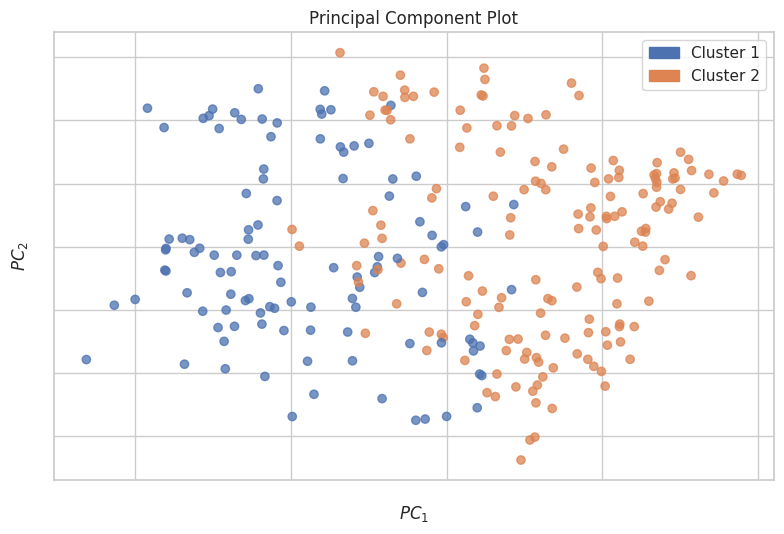

<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [ ]:
# Cluster visualization in a 2D space
# Define cluster names
classes = ['Cluster 1', 'Cluster 2']

# Calculate information retention with Sklearn PCA
pca = SklearnPCA(n_components=2)
pca.fit(dfs)

# Calculate the percentage of variance explained by each principal component
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Principal Component 1: {explained_variance[0]:.2f}% of variance explained")
print(f"Principal Component 2: {explained_variance[1]:.2f}% of variance explained")

# Visualize clusters with feature projection
pca_viz = YellowbrickPCA(scale=True, proj_features=True, classes=classes)
pca_viz.fit_transform(dfs, kmeans_labels)
pca_viz.show()

# Visualize clusters without feature projection
pca_viz = YellowbrickPCA(scale=True, proj_features=False, classes=classes)
pca_viz.fit_transform(dfs, kmeans_labels)
pca_viz.show()

#### K-Means with Dimension Reduction (PCA)
We also try to use K-means with the data after the dimensions have been reduced.\
We use 7 components, which from the section on dimension reduction means that about 81% of the information is explained.

In [ ]:
# Initialize PCA
pca = SklearnPCA(n_components=7)
data_pca = pca.fit_transform(dfs)

We test for the number of classes using the Elbow visualizer and by calculating silhouette scores for the data with reduced dimensions.

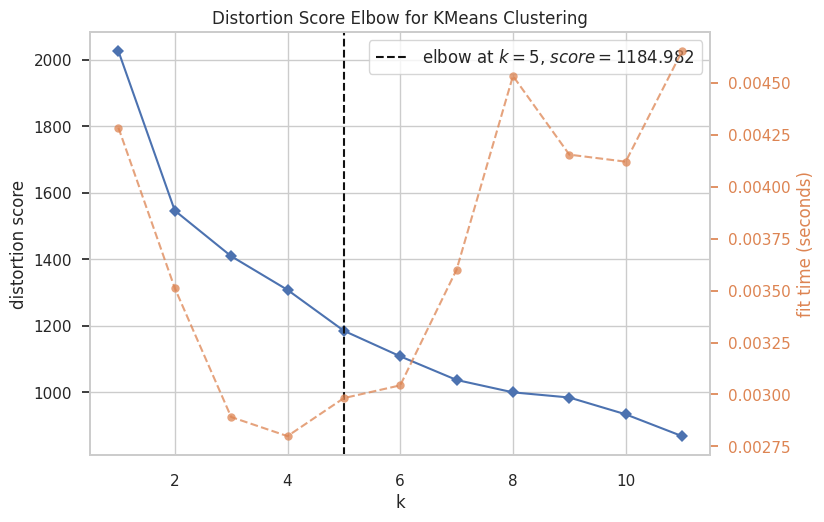

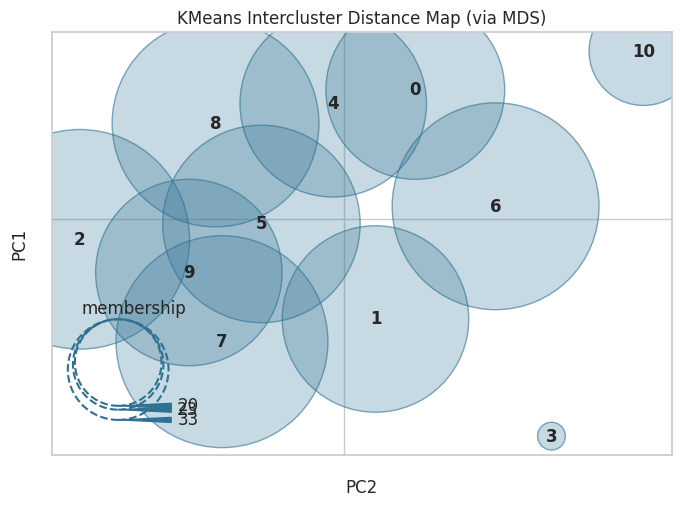

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
model = KMeans(random_state=42)

elbow_viz = KElbowVisualizer(model, k=(1, 12))
elbow_viz.fit(data_pca)
elbow_viz.show()

# Inter-cluster Distance Map
intercluster_viz = InterclusterDistance(model)
intercluster_viz.fit(dfs)
intercluster_viz.show()

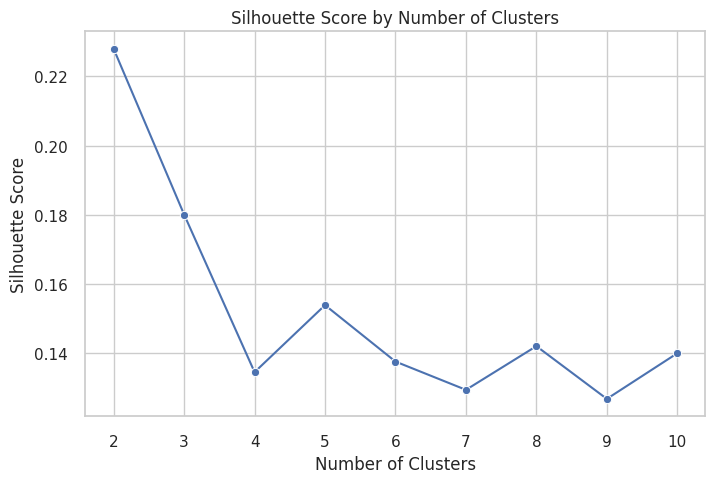

In [ ]:
# Manual calculation of silhouette scores for different cluster counts
silhouette_scores = []
range_clusters = range(2, 11)
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    silhouette_scores.append(score)

# Plot silhouette scores using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range_clusters), y=silhouette_scores, marker='o', color='b')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

As before, we also choose to use 2 clusters as the graph shows that the score reduces as the number of classes increase.

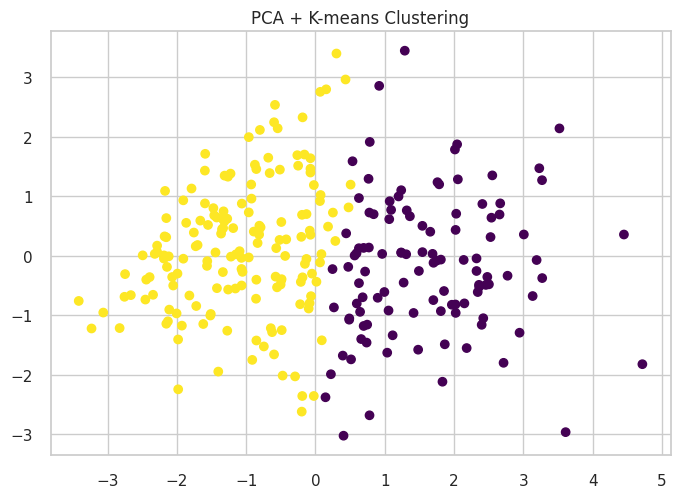

In [ ]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans.fit_predict(data_pca)

# Visualize
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_pca_labels, cmap='viridis')
plt.title('PCA + K-means Clustering')
plt.show()

Cluster 1
               Age         Sex  Chest pain type          BP  Cholesterol  \
count  108.000000  108.000000       108.000000  108.000000   108.000000   
mean    59.398148    0.750000         3.527778  135.564815   257.185185   
std      7.373785    0.435031         0.869615   18.394063    57.967304   
min     40.000000    0.000000         1.000000  100.000000   149.000000   
25%     55.000000    0.750000         3.000000  123.750000   222.500000   
50%     60.000000    1.000000         4.000000  132.000000   254.000000   
75%     64.000000    1.000000         4.000000  145.000000   283.750000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    108.000000   108.000000  108.000000       108.000000     108.000000   
mean       0.166667     1.296296  132.314815         0.583333       1.931481   
std        0.374415     0.949759   20.445802         0.495305       1.139

ValueError: Shape of passed values is (11, 7), indices imply (11, 20)

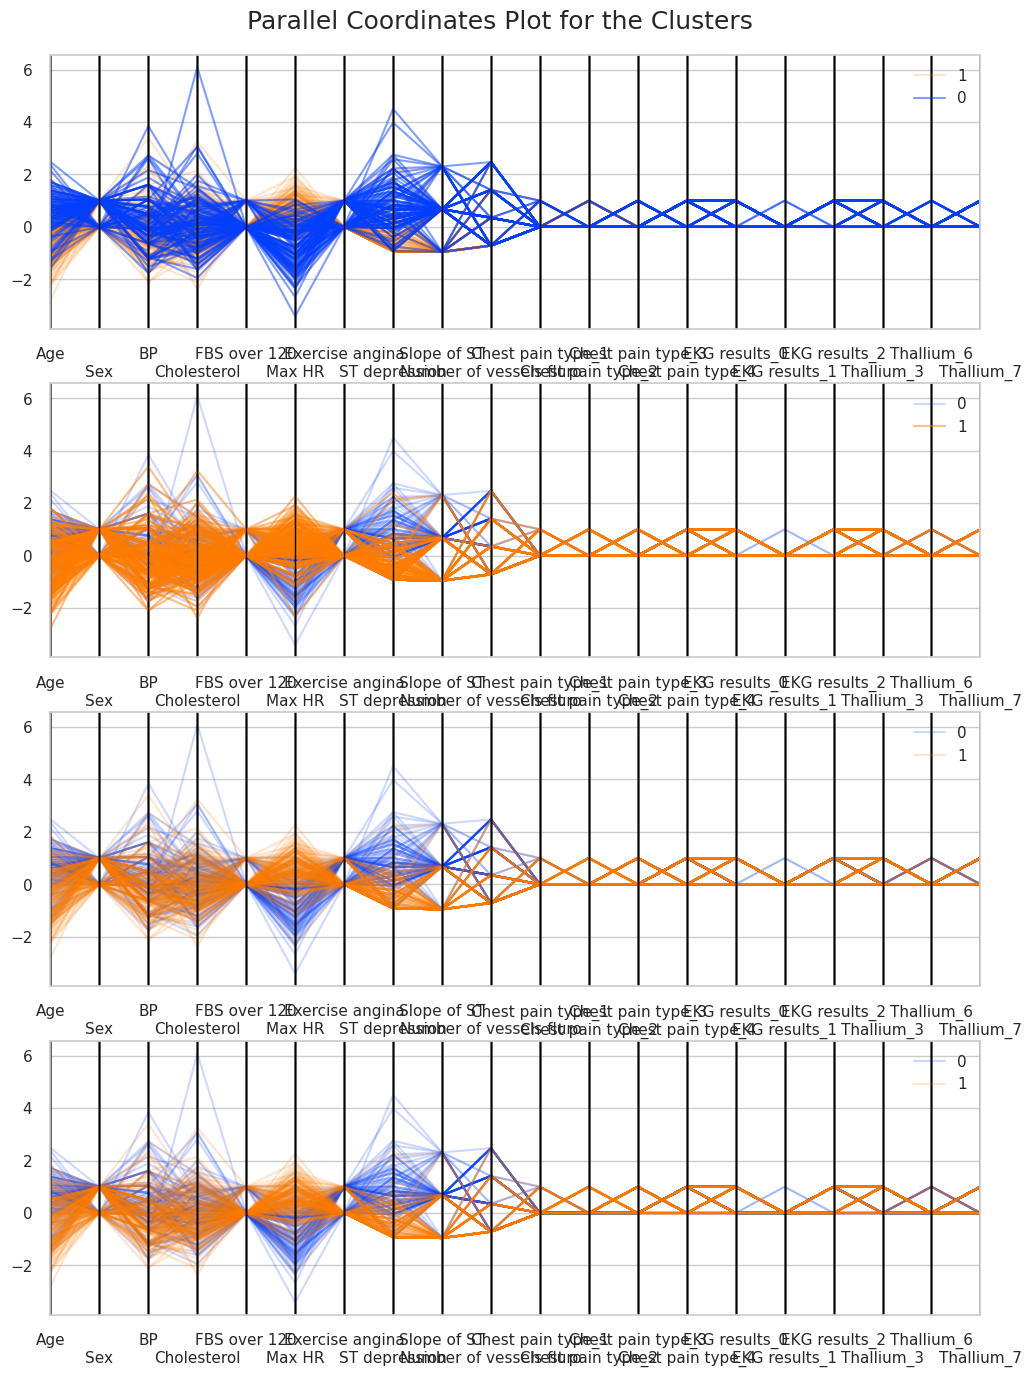

In [ ]:
# Cluster Characterization
# Filter data based on cluster labels
cluster1 = df[kmeans_pca_labels == 0]
cluster2 = df[kmeans_pca_labels == 1]

# Display descriptive statistics for each cluster
print('Cluster 1\n', cluster1.describe())
print('Cluster 2\n', cluster2.describe())


# Add cluster labels to normalized data
dfs_clustered = pd.DataFrame(dfs, index=dfs.index, columns=dfs.columns)
dfs_clustered["cluster"] = kmeans_pca_labels

# Plot parallel coordinates for each cluster
display_parallel_coordinates(dfs_clustered, 4)

# Create DataFrame containing the cluster centroids
centroids = pd.DataFrame(model.cluster_centers_, columns=dfs.columns)
centroids['cluster'] = centroids.index

# Plot parallel coordinates for centroids
display_parallel_coordinates_centroids(centroids, 4)

### Hierachical Clustering
We perform Hierachical clustering and use Gower's distance instead of Euclidean, which is the default because our data contains both categorical and continous data.

<ipython-input-76-d4b57c566877>:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='ward')


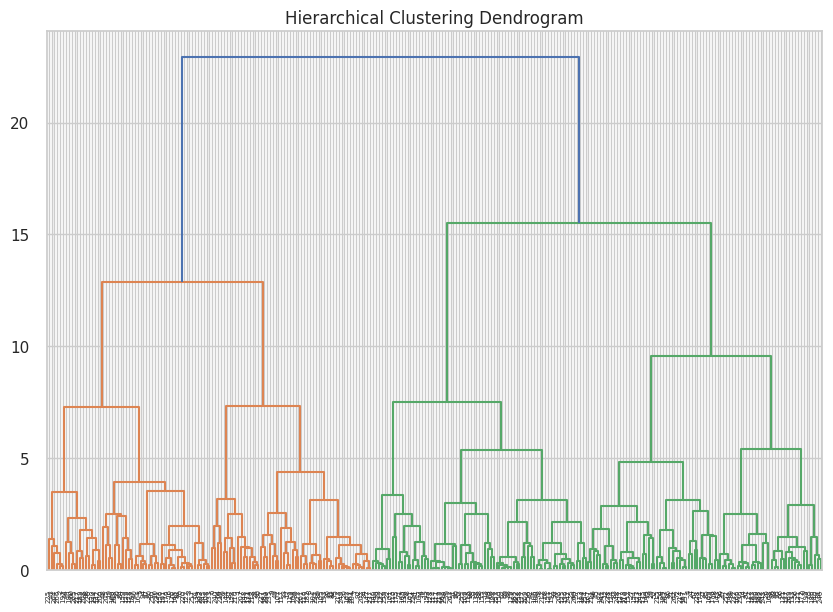

In [ ]:
#### HC with Gower distance
#  Calculate Gower distance
gower_dist = gower.gower_matrix(dfs)

# Perform hierarchical clustering
Z = linkage(gower_dist, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

From the dendogram, we infer that either 2 or 4 classes are optimal for the data.\
We plot inertia evolution by the number of clusters to observe which number of clusters is best. The point on the graph where there is the most drop in inertia shows the best number of classes.

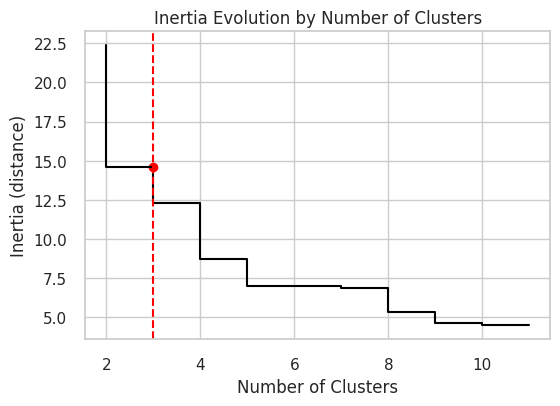

In [ ]:
# Plot of within-cluster inertia (distance change)
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(2, len(last) + 2)
plt.figure(figsize=(6, 4))
plt.step(idxs, last_rev, c="black")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (distance)")
plt.title("Inertia Evolution by Number of Clusters")
# Highlighting scenario with 4 clusters
num_clusters = 3
plt.scatter(idxs[np.where(idxs == num_clusters)], last_rev[np.where(idxs == num_clusters)], c="red")
plt.axvline(x=num_clusters, color='red', linestyle='--')
plt.show()

We then create clusters and visulaize them in 2D (using PCA1 and PCA2) by cutting the dendogram at the desired height.\
To get 2 classes, we can cut the dendogram at 20 and to get 4 classes, we can cut the dendogram at 15.

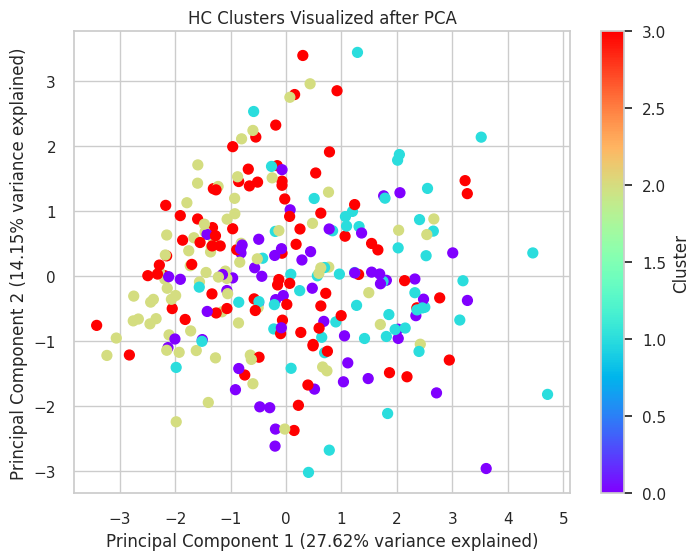

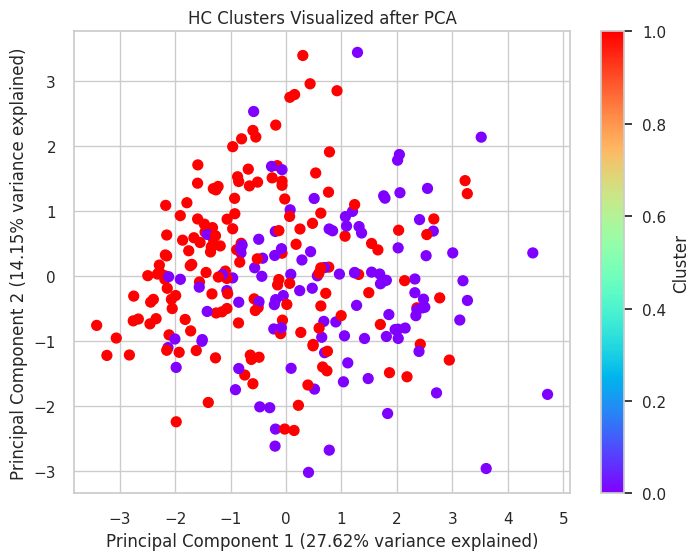

In [ ]:
# Create clusters by cutting the dendrogram at height t=10 and t=18
clusters_15 = fcluster(Z, t=10, criterion='distance')
clusters_20 = fcluster(Z, t=20, criterion='distance')

# Re-encode cluster labels to start at 0
label_encoder = preprocessing.LabelEncoder()
clusters_encoded1 = label_encoder.fit_transform(clusters_15)
clusters_encoded2 = label_encoder.fit_transform(clusters_20)

# PCA for 2D visualization
pca = SklearnPCA(n_components=7)
dfs_pca = pca.fit_transform(dfs)

# Visualize clusters after PCA
plt.figure(figsize=(8, 6))
plt.scatter(dfs_pca[:, 0], dfs_pca[:, 1], c=clusters_encoded1, cmap='rainbow', s=50)
plt.title("HC Clusters Visualized after PCA")
plt.xlabel(f"Principal Component 1 ({100*pca.explained_variance_ratio_[0]:.2f}% variance explained)")
plt.ylabel(f"Principal Component 2 ({100*pca.explained_variance_ratio_[1]:.2f}% variance explained)")
plt.colorbar(label='Cluster')
plt.show()

# Visualize clusters after PCA
plt.figure(figsize=(8, 6))
plt.scatter(dfs_pca[:, 0], dfs_pca[:, 1], c=clusters_encoded2, cmap='rainbow', s=50)
plt.title("HC Clusters Visualized after PCA")
plt.xlabel(f"Principal Component 1 ({100*pca.explained_variance_ratio_[0]:.2f}% variance explained)")
plt.ylabel(f"Principal Component 2 ({100*pca.explained_variance_ratio_[1]:.2f}% variance explained)")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
silhouette_hc = silhouette_score(gower_dist, clusters_20 , metric="precomputed")

print("Silhouette Score:", silhouette_hc)


Silhouette Score: 0.316159


#### Agglomerative Hierachical Clustering

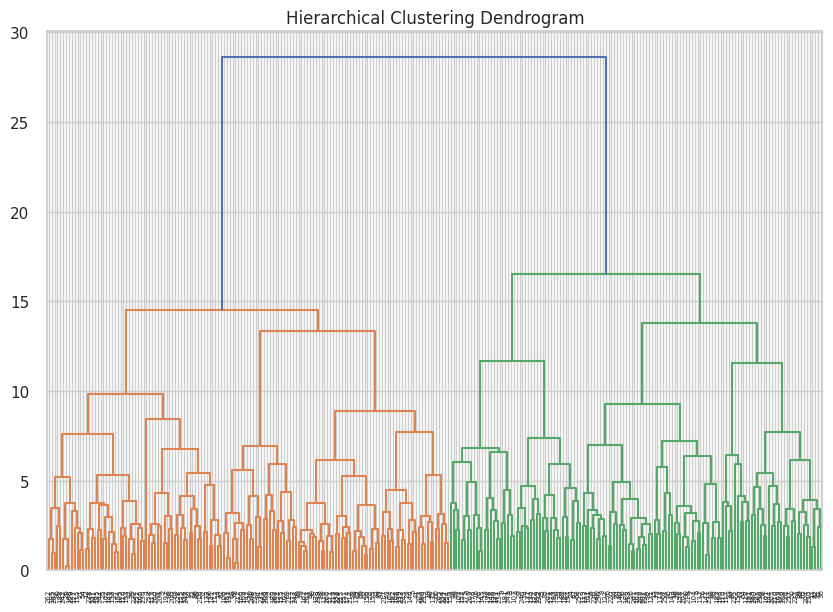

In [ ]:
ahc = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(dfs)
ahc_labels = ahc.labels_

# Visualize Dendrogram
Z1 = linkage(dfs, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z1)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

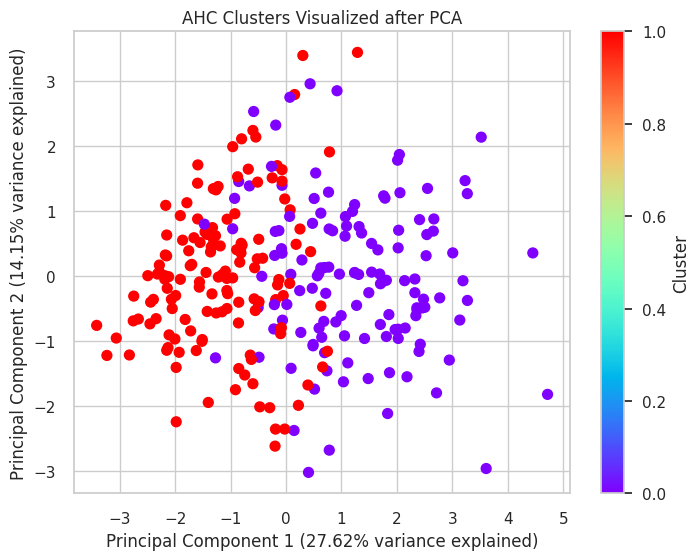

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(dfs_pca[:, 0], dfs_pca[:, 1], c=ahc_labels, cmap='rainbow', s=50)
plt.title("AHC Clusters Visualized after PCA")
plt.xlabel(f"Principal Component 1 ({100*pca.explained_variance_ratio_[0]:.2f}% variance explained)")
plt.ylabel(f"Principal Component 2 ({100*pca.explained_variance_ratio_[1]:.2f}% variance explained)")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
silhouette_hc = silhouette_score(dfs, ahc_labels)

print("Silhouette Score:", silhouette_hc)

Silhouette Score: 0.15518885271685218


From comparison of using default distance (Euclidean distance) and Gower distance for clustering, Gower matrix does better with a silhouette score that is twice that of agglomerative clustering.

#### Adjusted Rand Score
Here we compare the model labels with the labels of the data. This can be used as a measure of performance.
The models all have less thann 35% score which may suggest that clustering is not a good method to classify the data.

In [ ]:
y = target.to_numpy()
print ("Scores as related to initial labels")
print("K-means: {:0.4%}".format(adjusted_rand_score(y, kmeans_labels)))
print("K-means with PCA: {:0.4%}".format(adjusted_rand_score(y, kmeans_pca_labels)))
print("HC with Gower's: {:0.4%}".format(adjusted_rand_score(y, clusters_encoded2)))
print("AHC: {:0.4%}".format(adjusted_rand_score(y, ahc_labels)))

Scores as related to initial labels
K-means: 33.1156%
K-means with PCA: 32.2600%
HC with Gower's: 25.0794%
AHC: 27.3924%
